In [9]:
import gymnasium as gym
import numpy as np
import ipywidgets as widgets
import sys

sys.path.append('../')
import support_modules as sm

# Cliff Walking

## Description
<div style="text-align: justify">    
The game starts with the player at location [3, 0] of the 4x12 grid world with the goal located at [3, 11]. If the player reaches the goal the episode ends.

A cliff runs along [3, 1..10]. If the player moves to a cliff location it returns to the start location.

The player makes moves until they reach the goal.

Adapted from Example 6.6 (page 132) from Reinforcement Learning: An Introduction by Sutton and Barto.
</div>

https://gymnasium.farama.org/environments/toy_text/cliff_walking/

# Random policy

## Single episode

In [10]:
env = gym.make('CliffWalking-v0', render_mode='human', max_episode_steps=20)
state, _ = env.reset()
done = False

while not done:
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    env.render()
    
    done = sm.Q_Learning_Agent.evaluate_done(terminated,truncated)

env.close()

## Exploratory 1000 episodes

In [11]:
env = gym.make('CliffWalking-v0', render_mode=None, max_episode_steps=20)

rewards = list()
success = list()

for episode in range(1000):
    state, _ = env.reset()
    ep_reward = 0
    done = False

    while not done:
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        ep_reward += reward
        
        done = sm.Q_Learning_Agent.evaluate_done(terminated,truncated)
    
    rewards.append(ep_reward)
    success.append(terminated)

env.close()
print(f'Success rate: {sum(success)/len(success)}')
print(f'Average reward: {sum(rewards)/len(rewards)}')

Success rate: 0.0
Average reward: -264.134


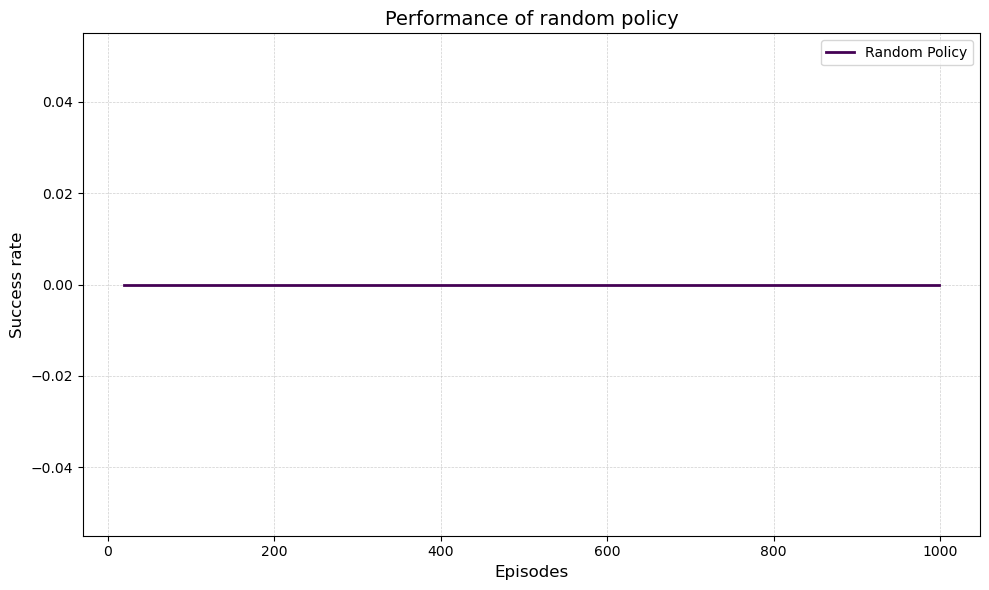

In [7]:
sm.visualizations.plot_moving_average([success],['Random Policy'],20,
                                      title='Performance of random policy', ylabel='Success rate')

# Q-Learning

### Hyperparameters

In [ ]:
# Flexible Parameters (ipywidgets)
EPISODES_W = widgets.IntSlider(value = 2500, min = 50, max = 10000, step = 50, description = 'Episodes')

LEARNING_RATE_W = widgets.FloatSlider(value = 0.1, min = 0, max = 1, step = 0.05, description = 'Learning r.')
DISCOUNT_W = widgets.FloatSlider(value = 0.95, min = 0, max = 1, step = 0.05, description = 'Discount f.')

epsilon_W = widgets.FloatSlider(value = 0.5, min = 0, max = 1, step = 0.05, description = 'Exploration r.')

display(EPISODES_W,LEARNING_RATE_W,DISCOUNT_W,epsilon_W)

START_EPSILON_DECAYING = 1                      # First episode at which decay epsilon

## Training

In [ ]:
env = gym.make('MountainCar-v0', render_mode=None)

# Retrieving 
EPISODES = EPISODES_W.value; LEARNING_RATE = LEARNING_RATE_W.value
DISCOUNT = DISCOUNT_W.value; epsilon = epsilon_W.value
epsilon_decaying_value = epsilon / ((EPISODES//1.5) - START_EPSILON_DECAYING)     # Amount of decayment of epsilon    

# Generate the q_table 
q_table = sm.Q_Learning_Agent.generate_q_table('random',env,[1],low=-2,high=0)

# Rewards
ep_rewards = list()
success = list()
epsilons = list()


### Training
for episode in range(EPISODES):
    
    episode_reward = 0
    state, info = env.reset()
    done = False
    
    while not done: 

        if np.random.random() > epsilon:                    # Randomize actions with epsilon
            action = np.argmax(q_table[state])     # Action taken from the argmax of the current state
        else:
            action = env.action_space.sample()              # Action taken ramdomly
        
        new_state, reward, terminated, truncated, info = env.step(action)       # Retrieve information
        done = sm.Q_Learning_Agent.evaluate_done(terminated,truncated)

        episode_reward += reward
        
        if not done: 
            q_table = sm.Q_Learning_Agent.update_q_table(q_table,discrete_state,new_discrete_state,action,reward,LEARNING_RATE,DISCOUNT)
        
        elif terminated:
            q_table[[state] + (action, )] = 0        # Update value when goal is reached
        
        discrete_state = new_state                 # Update state
    
    epsilon = sm.Q_Learning_Agent.decay_epsilon(epsilon,episode,epsilon_decaying_value,START_EPSILON_DECAYING,EPISODES//1.5)
    
    ep_rewards.append(episode_reward)
    success.append(terminated)
    epsilons.append(epsilon)
     
env.close()

## Testing